In [13]:
%load_ext autoreload 
%autoreload 2

import os, sys
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(os.path.join(os.getcwd(), ".."))

import math
import numpy as np
import pandas as pd
from numpy import array
from numpy import array, arange, abs as np_abs
from numpy.fft import rfft, rfftfreq
from math import sin, pi
from scipy import signal
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import importlib
import model as md
import view as vw

importlib.reload(md)
importlib.reload(vw)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
c:\Users\Артем\Desktop\Вуз\Аспирантура\Диссертация\Алгоритм\Relaxation_frequency_phase_algorithm\notebooks\Complex_ms\..


<module 'view' from 'c:\\Users\\Артем\\Desktop\\Вуз\\Аспирантура\\Диссертация\\Алгоритм\\Relaxation_frequency_phase_algorithm\\view\\__init__.py'>

In [14]:
def filter_butter_bandpass(time, samples, Fcutoff, scope, order=2):
    lowcut = Fcutoff - scope
    highcut = Fcutoff + scope
    
    Fs = 1 / np.mean(np.diff(time))
    nyq = 0.5 * Fs
    low = lowcut / nyq
    high = highcut / nyq

    if not (0 < low < high < 1):
        raise ValueError(f"Invalid cutoff frequencies: low={low}, high={high}")

    sos = signal.butter(order, [low, high], btype='band', output='sos')
    filtered = signal.sosfiltfilt(sos, samples)
    return time, filtered


In [15]:
def add_realistic_noise(time, signal, F0, Fs,
                        low_freq_amp=0.3,
                        mirror_amp=0.3,
                        harmonic_amp=0.5,
                        white_noise_amp=0.05):
    """
    Добавляет типичные физические помехи к сигналу с несущей F0:
      - низкочастотный дрейф (около 0 Гц)
      - зеркальная гармоника (Fs - F0)
      - вторая гармоника (2*F0)
      - белый шум
    """
    drift = low_freq_amp * np.sin(2*np.pi*1e3*time)          # ~1 кГц
    mirror = mirror_amp * np.sin(2*np.pi*(Fs-F0)*time)
    harmonic = harmonic_amp * np.sin(2*np.pi*(2*F0)*time)
    white = white_noise_amp * np.random.randn(len(signal))
    return signal + drift + mirror + harmonic + white

In [16]:
F_main_real=440e3
duration = 100e-6

fs = F_main_real
phase_real=17.305

fs_mass=[]
t_mass=[]
U_mass=[]
I_mass=[]

for i in range (5,50,1):

    t = np.arange(0, duration, 1/(i*fs))
    U = md.generate_sin(t,F_main_real,2)
    I = md.generate_sin(t,F_main_real,2,phase_real)

    U=add_realistic_noise(t,U,F_main_real,fs)
    I=add_realistic_noise(t,I,F_main_real,fs)

    t_f, U_f=filter_butter_bandpass(t,U,F_main_real,150e3,2)
    t_f, I_f=filter_butter_bandpass(t,I,F_main_real,150e3,2)

    fs_mass.append(i*fs)
    t_mass.append(t_f)
    U_mass.append(U_f)
    I_mass.append(I_f)

6600000.0
439999.99999999994


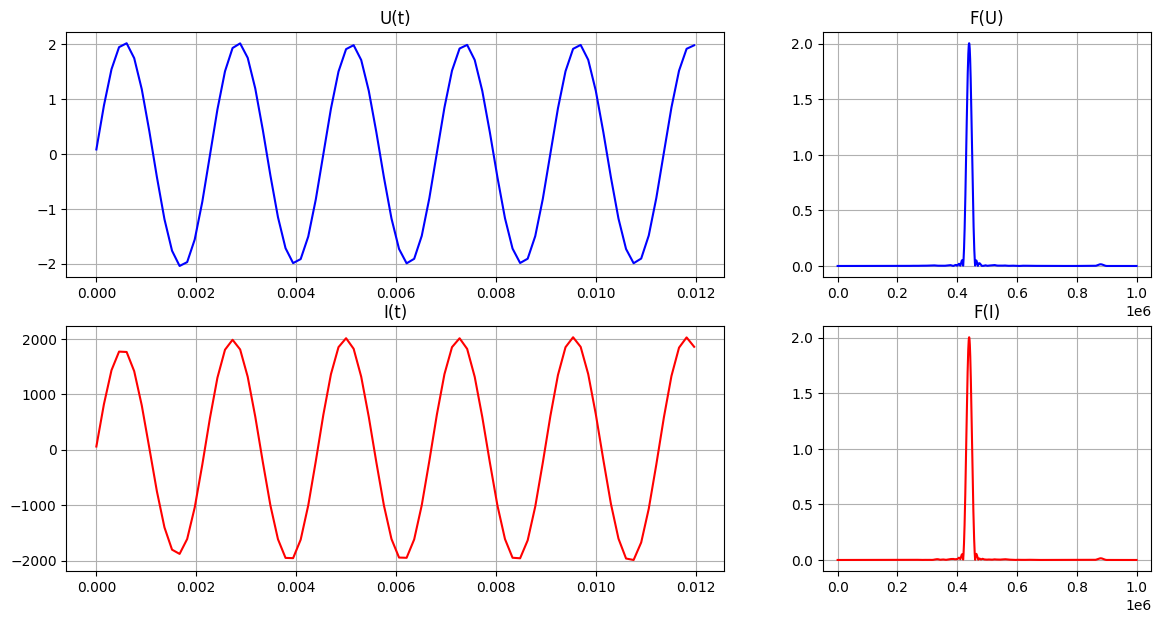

In [17]:
index=10
print(fs_mass[index])

F,V = md.get_spectrum3(t_mass[index],U_mass[index])

F_peak_calc = F[np.argmax(V)]
T=1/F_peak_calc

print(F_peak_calc)

T_counts=md.convert_to_counts(t_mass[index],T)

window=T_counts*5

vw.show_I_U_2(t_mass[index],I_mass[index],U_mass[index],0,window)

In [18]:
Kde_maxpoint=[]
Kde_hilbert =[]
Kde_FFT     =[]
Kde_lockin  =[]
Kde_xcorr   =[]

for i in range (0,len(U_mass),1):

    print(i)
    F,V = md.get_spectrum3(t_mass[i],U_mass[i])
    F_peak_calc = F[np.argmax(V)]

    time_maxpoint,  phase_maxpoint  =md.get_phase_maxpoint_diff(t_mass[i], U_mass[i], I_mass[i],F_peak_calc)
    time_hilbert,   phase_hilbert   =md.get_phase_hilbert(t_mass[i], U_mass[i], I_mass[i], F_peak_calc)
    time_FFT,       phase_FFT       = md.get_phase_FFT(t_mass[i], U_mass[i], I_mass[i], F_peak_calc)
    time_lockin,    phase_lockin    = md.get_phase_lockin(t_mass[i], U_mass[i], I_mass[i], F_peak_calc,5)
    time_xcorr,     phasse_xcorr    = md.get_phase_xcorr2(t_mass[i], U_mass[i], I_mass[i], F_peak_calc)

    try:
        Kde_maxpoint.append(md.get_kde_mode(phase_maxpoint))
    except:
        print("exept")
        Kde_maxpoint.append(0)
    Kde_hilbert.append(md.get_kde_mode(phase_hilbert))
    Kde_FFT.append(md.get_kde_mode(phase_FFT))
    Kde_lockin.append(md.get_kde_mode(phase_lockin))
    Kde_xcorr.append(md.get_kde_mode(phasse_xcorr))

0
1
2
3
4
exept
5
6
7
8
exept
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


In [19]:
Kde_maxpoint_diff   =np.subtract(Kde_maxpoint,phase_real)
Kde_hilbert_diff    =np.subtract(Kde_hilbert ,phase_real)
Kde_FFT_diff        =np.subtract(Kde_FFT     ,phase_real)
Kde_lockin_diff     =np.subtract(Kde_lockin  ,phase_real)
Kde_xcorr_diff      =np.subtract(Kde_xcorr   ,phase_real)

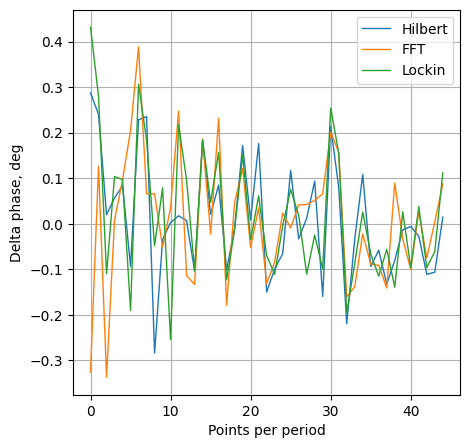

In [20]:
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot()
front=10

y=np.arange(0, len(fs_mass), 1)

#ax1.plot(y, Kde_maxpoint_diff, 'o-', label='Maxpoint', linewidth=1)
ax1.plot(y, Kde_hilbert_diff,  label='Hilbert', linewidth=1)
ax1.plot(y, Kde_FFT_diff,  label='FFT', linewidth=1)
ax1.plot(y, Kde_lockin_diff,  label='Lockin', linewidth=1)
#ax1.plot(y, Kde_xcorr_diff, 'o-', label='Xcorr', linewidth=1)


ax1.set_xlabel('Points per period', fontsize=front)
ax1.set_ylabel('Delta phase, deg', fontsize=front)
ax1.legend(fontsize=front)
ax1.grid(True)